In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!ln -s drive/My\ Drive/Colab\ Notebooks/Alura-Aulas_Suayder /content/Aula

ln: failed to create symbolic link '/content/Aula/Alura-Aulas_Suayder': Function not implemented


In [0]:
!ls Aula

dicionario512.csv  extracao_de_caracteristicas.ipynb
dicionario.csv	   INRIAPerson_Dataset


In [0]:
# Importação das bibliotecas necessárias
import cv2
from matplotlib import pyplot as plt

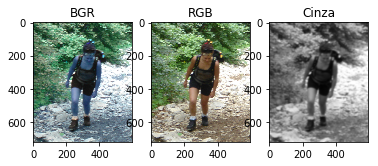

In [0]:
# Como ler uma imagem e converter os canais de cores

img_caminho = 'Aula/INRIAPerson_Dataset/treinamento/positivos/crop_000010.png'
img_teste_BGR = cv2.imread(img_caminho) #RGB
img_teste_RGB = cv2.cvtColor(img_teste_BGR, cv2.COLOR_BGR2RGB)
img_teste_cinza = cv2.cvtColor(img_teste_BGR, cv2.COLOR_BGR2GRAY)
#img_teste = cv2.imread(img_caminho,0) #GRAY SCALE

plt.subplot(131) 
plt.title('BGR')
plt.imshow(img_teste_BGR)
plt.subplot(132)
plt.title('RGB')
plt.imshow(img_teste_RGB)
plt.subplot(133)
plt.title('Cinza')
plt.imshow(img_teste_cinza, cmap='gray', interpolation='bicubic')
plt.show()

Dimenções da matriz:  (720, 594)
Nova dimenção:  (360, 360)


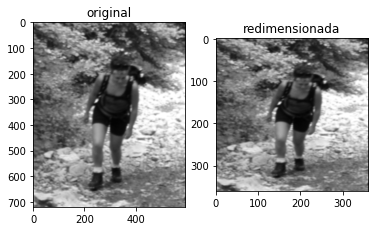

In [0]:
# Redimensionar

print("Dimenções da matriz: ",img_teste_cinza.shape)

img_teste_redimensionada = cv2.resize(img_teste_cinza, (360, 360),interpolation=cv2.INTER_CUBIC)

print("Nova dimenção: ",img_teste_redimensionada.shape)

plt.subplot(121)
plt.title('original')
plt.imshow(img_teste_cinza, cmap='gray', interpolation='bicubic')
plt.subplot(122)
plt.title('redimensionada')
plt.imshow(img_teste_redimensionada, cmap='gray', interpolation='bicubic')
plt.show()

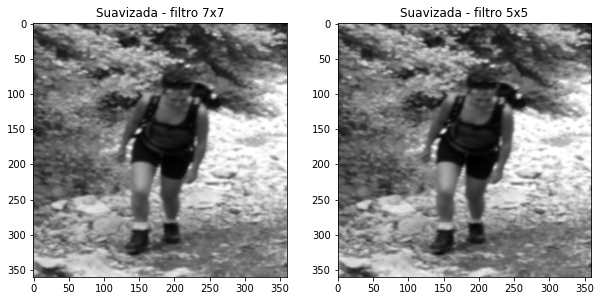

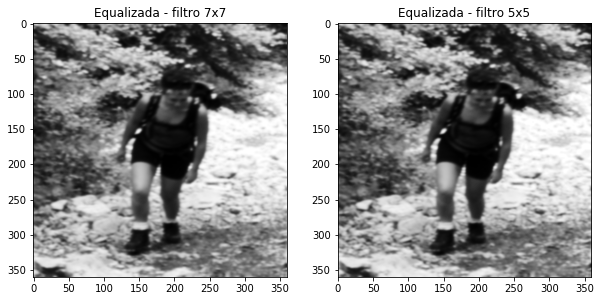

In [0]:
# Aplicação de filtros e equalização de imagens


img_teste_suavizada7 = cv2.GaussianBlur(img_teste_redimensionada, (7,7),1)
img_teste_suavizada5 = cv2.GaussianBlur(img_teste_redimensionada, (5,5),1)
img_teste_equalizada7 = cv2.equalizeHist(img_teste_suavizada7)
img_teste_equalizada5 = cv2.equalizeHist(img_teste_suavizada5)


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Suavizada - filtro 7x7')
plt.imshow(img_teste_suavizada7, cmap='gray', interpolation='bicubic')
plt.subplot(122)
plt.title('Suavizada - filtro 5x5')
plt.imshow(img_teste_suavizada5, cmap='gray', interpolation='bicubic')
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Equalizada - filtro 7x7')
plt.imshow(img_teste_equalizada7, cmap='gray', interpolation='bicubic')
plt.subplot(122)
plt.title('Equalizada - filtro 5x5')
plt.imshow(img_teste_equalizada5, cmap='gray', interpolation='bicubic')
plt.show()

In [0]:
def get_descritores(img_caminho):
    ALTURA = 360
    LARGURA = 360

    # Ler imagens
    img_teste = cv2.imread(img_caminho) #RGB
    img_cinza = cv2.cvtColor(img_teste, cv2.COLOR_BGR2GRAY)


    # Redimensionar
    img_redimencionada = cv2.resize(img_cinza, (LARGURA, ALTURA),interpolation=cv2.INTER_CUBIC)

    # Remover o ruído (suavizar a imagem)
    img_suavizada = cv2.GaussianBlur(img_redimencionada, (5,5),1)
    img_equalizada = cv2.equalizeHist(img_suavizada)

    orb = cv2.ORB_create(nfeatures = 512)

    # Determinar key points
    pontos_chave = orb.detect(img_equalizada, None)

    pontos_chave, descritores = orb.compute(img_equalizada, pontos_chave)

    return descritores

In [0]:
descritor = get_descritores(img_caminho)

print("Formato descritor: ", descritor.shape)
print("\n descritor[0]: ", descritor[0])
print("\n descritor[1]: ", descritor[1])

Formato descritor:  (512, 32)

 descritor[0]:  [101 225 145  14 217  77  70 168  66 224  41  72 242 240  89 178 144  76
 112 126 151  34 251  57  45  28   5  60 216  51  66   4]

 descritor[1]:  [199  20 239  87 226 106 173  27 120 251  31 246 208 118 222 107  55  71
 121 191 177 212 191  66  76  42 255 196 141 225 177 117]


In [0]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np
import os

In [0]:
QUANTIDADE_PALAVRAS_VIRTUAIS = 512

class PacoteDePalavrasVirtuais:
    
    def gerar_dicionario(self, lista_descritores):

        kmeans = KMeans(n_clusters = QUANTIDADE_PALAVRAS_VIRTUAIS) # 256 Corresponde ao número de palavras virtuais que serão geradas
        kmeans = kmeans.fit(lista_descritores)
        self.dicionario = kmeans.cluster_centers_

    def histograma_de_frequencia(self, descritores):
        
        try:
            algoritmo_knn = NearestNeighbors(n_neighbors=1)
            algoritmo_knn.fit(self.dicionario)
            mais_proximos = algoritmo_knn.kneighbors(descritores, return_distance=False).flatten()
            histograma_caracteristicas = np.histogram(mais_proximos, bins=np.arange(self.dicionario.shape[0]+1))[0]
            return histograma_caracteristicas
        
        except AttributeError:
            print("O atributo dicionário não foi definido")
            
    def salvar_dicionario(self, caminho='', nome_dicionario = 'dicionario512.csv'):
        try:
            np.savetxt(os.path.join(caminho, nome_dicionario), self.dicionario, delimiter=',', fmt='%f')
            print('Dicionario salvo com sucesso!')
        except AttributeError:
            print("Dicionario esta vazio")
    
    def carregar_dicionario(self, caminho='', nome_dicionario = 'dicionario512.csv'):
        
        self.dicionario = np.loadtxt(os.path.join(caminho, nome_dicionario), delimiter=',')

In [0]:
a = PacoteDePalavrasVirtuais()
a.gerar_dicionario(descritor)

print("Formato dicionario: ",a.dicionario.shape)

print("\nAtributo dicionario: ", a.dicionario[0])

Formato dicionario:  (512, 32)

Atributo dicionario:  [189. 228. 109. 111. 214.  79. 231. 252.  82. 118. 101.  26.  83. 121.
  27.  33.  57. 204.  18. 107. 227. 244. 253.  63. 127. 171. 101.  36.
 117. 251. 214. 224.]


In [0]:
a.carregar_dicionario('Aula')

print("Formato dicionario: ",a.dicionario.shape)

print("\nAtributo dicionario: ", a.dicionario[0])

Formato dicionario:  (512, 32)

Atributo dicionario:  [ 96.400285 164.139601 215.732194  90.547009 214.611111 109.216524
 109.867521 203.233618  76.415954 198.017094 136.042735 195.108262
  90.548433 172.534188 184.61396   71.672365  87.102564 201.924501
 161.69943  130.216524 146.709402 159.292023 181.102564  79.128205
 145.216524 172.666667  67.166667 190.367521 211.280627 214.115385
 148.133903 202.861823]


In [0]:
histograma_descritor = a.histograma_de_frequencia(descritor)

print("Formato histograma: ",histograma_descritor.shape)

print("\nAtributo histograma: ", histograma_descritor)

Formato histograma:  (512,)

Atributo histograma:  [0 2 3 1 0 2 0 2 2 0 1 0 2 0 2 0 0 3 1 0 1 1 0 4 0 1 1 1 0 0 0 1 1 1 2 5 0
 0 1 0 3 1 2 0 1 2 0 0 1 1 3 0 1 0 0 1 0 1 0 0 0 1 1 6 2 0 4 0 0 1 0 0 0 0
 1 1 1 0 1 2 1 0 0 1 0 3 1 3 1 3 4 0 0 0 1 4 0 0 1 1 4 0 1 0 3 2 2 0 2 0 0
 0 3 0 2 1 1 2 1 0 1 1 0 0 1 2 2 0 1 1 0 0 0 1 0 1 2 0 0 0 0 0 0 2 1 0 1 1
 4 2 0 0 1 1 0 0 1 2 0 2 5 0 0 0 1 0 0 1 1 3 2 2 0 1 0 1 0 0 1 0 1 0 0 2 0
 0 0 2 3 2 2 1 0 1 0 1 0 3 0 0 1 0 4 0 2 1 0 1 1 0 0 0 0 0 2 0 0 1 2 2 3 0
 1 5 3 0 1 2 1 1 0 0 2 1 2 2 3 2 1 1 0 2 0 0 1 3 1 2 1 0 1 0 1 1 0 1 0 2 0
 0 3 1 0 0 2 0 3 3 0 1 0 0 0 1 1 0 1 1 3 1 3 1 1 0 0 0 0 1 1 3 0 4 1 0 0 1
 0 1 0 0 1 0 2 1 1 1 2 0 0 2 0 0 1 1 3 1 2 1 1 3 0 2 2 1 0 0 0 0 1 1 1 2 1
 1 0 5 0 1 2 2 0 3 0 1 3 0 1 1 1 0 0 3 0 2 1 1 0 1 2 3 0 0 1 1 0 1 0 1 1 1
 2 1 0 6 2 1 0 1 1 3 1 1 0 2 2 1 0 6 0 0 0 2 2 0 0 2 1 1 0 1 1 2 2 0 1 0 0
 0 1 1 0 0 0 2 0 0 1 1 1 3 1 3 0 0 1 2 0 0 2 1 0 0 0 2 0 1 1 0 1 0 3 1 1 0
 1 0 2 0 1 0 1 5 0 0 0 2 0 0 0 3 0 2 0 1 2 0 0 2 

In [0]:
def salvar_descritor(descritores, caminho, nome_arquivo):

    descritores = descritores.reshape((1,descritores.size))

    arquivo=open(os.path.join(caminho, nome_arquivo),'a')

    np.savetxt(arquivo, descritores, delimiter=',', fmt='%i')
    arquivo.close()

# MAIN - Geração de características

### OBSERVAÇÃO: A  medição de tempo abaixo não faz parte do código final

In [0]:
import time

In [0]:
begin = time.time()

DICIONARIO_NOME = 'dicionario.csv'

dados_treinamento = ['Aula/INRIAPerson_Dataset/treinamento/positivos/',
'Aula/INRIAPerson_Dataset/treinamento/negativos/']

# Rotina para criação do dicionário de palavras virtuais
descritores = np.empty((0,32), dtype=np.uint8)
for caminho in dados_treinamento:

    for raiz, diretorios, arquivos in os.walk(caminho):

        for arquivo in arquivos: #Somente 400 exemplos positivos e 400 exemplos negativos
            if arquivo.endswith('.png'):
                orb_descritor = get_descritores(os.path.join(caminho, arquivo))
                descritores = np.append(descritores, orb_descritor, axis=0)

# Bag of Visual words - gerar dicionário de palavras

img_representacao = PacoteDePalavrasVirtuais()
img_representacao.gerar_dicionario(descritores)
img_representacao.salvar_dicionario('Aula/', DICIONARIO_NOME)

end = time.time()

Dicionario salvo com sucesso!


In [0]:
print("Tempo de execução da função acima (s): ", (end-begin))

Tempo de execução da função acima (s):  6132.21505522728


In [0]:
#Usado somente quando o run time é perdido

DICIONARIO_NOME = 'dicionario.csv'

dados_treinamento = ['Aula/INRIAPerson_Dataset/treinamento/positivos/',
'Aula/INRIAPerson_Dataset/treinamento/negativos/']

img_representacao = PacoteDePalavrasVirtuais()
img_representacao.carregar_dicionario('Aula', DICIONARIO_NOME)

print(img_representacao.dicionario.shape)

(512, 32)


In [0]:
img_representacao = PacoteDePalavrasVirtuais()

img_representacao.carregar_dicionario('Aula')

print(img_representacao.dicionario[0])

[ 80.405486 117.650111 121.759822 204.186064 190.570793 151.854707
 196.322461 145.196442  79.219422  57.309859 186.956264  56.787991
  90.739807  84.880652  68.452928 102.32172  170.064492 166.618977
  62.815419 158.968866  99.82209  180.489993  71.759822 185.812454
 149.094144 193.435137 157.918458  94.011861 174.762787 132.693106
 221.927354 156.3106  ]


In [0]:
# computar descritores gerando histograma de cada imagem separadamente

NOME_DESCRITORES = 'orb_descritores.csv'

for caminho in dados_treinamento:
    
    arquivo_descritores = os.path.join(caminho,NOME_DESCRITORES)
    if os.path.exists(arquivo_descritores):
        os.remove(arquivo_descritores)

    for raiz, diretorios, arquivos in os.walk(caminho):
        for arquivo in arquivos: #Somente 400 exemplos positivos e 400 exemplos negativos
            if arquivo.endswith('.png'):
                descritor = get_descritores(os.path.join(caminho, arquivo))
                hitograma_descritor = img_representacao.histograma_de_frequencia(descritor)
                salvar_descritor(hitograma_descritor, caminho, NOME_DESCRITORES)
print("extracao de caracteristicas finalizada e descritores salvos")

extracao de caracteristicas finalizada e descritores salvos


In [0]:
!ls Aula/INRIAPerson_Dataset/treinamento/positivos/*.csv
!ls Aula/INRIAPerson_Dataset/treinamento/negativos/*.csv

Aula/INRIAPerson_Dataset/treinamento/positivos/orb_descritores512.csv
Aula/INRIAPerson_Dataset/treinamento/positivos/orb_descritores.csv
Aula/INRIAPerson_Dataset/treinamento/negativos/orb_descritores512.csv
Aula/INRIAPerson_Dataset/treinamento/negativos/orb_descritores.csv


# Rotina de classificação

In [0]:
def carregar_descritores(caminho, nome_arquivo = 'orb_descritores.csv'):

    descritores = np.loadtxt(os.path.join(caminho, nome_arquivo), delimiter=',')
    print("formato do array de descritores: ",descritores.shape) #Para justificar o '400' do bloco de classificação
    return descritores

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
#Carregar os descritores salvos

NOME_DESCRITORES = 'orb_descritores.csv'

descritores = np.empty((0,QUANTIDADE_PALAVRAS_VIRTUAIS))
for caminho in dados_treinamento:
    descritores = np.append(descritores, carregar_descritores(caminho, NOME_DESCRITORES), axis=0)

formato do array de descritores:  (400, 512)
formato do array de descritores:  (400, 512)


In [0]:
#KNN para classificar as imagens

#Contar aruivos na pasta

QUANTIDADE_DE_DADOS_TREINAMENTO = 400
QUANTIDADE_DE_DADOS_TESTE = 100

rotulos = np.ones(QUANTIDADE_DE_DADOS_TREINAMENTO, dtype=np.uint8) #Rotular as primeiras 400 caracteristicas como 1 - Exemplos sem imagem
rotulos = np.append(rotulos, np.zeros(QUANTIDADE_DE_DADOS_TREINAMENTO, dtype=np.uint8)) #Rotular as outras 400 como zero - Exemplos sem imagem

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(descritores, rotulos)

# Ler imagens. 100 positivas e 100 negativas

dados_teste = ['Aula/INRIAPerson_Dataset/teste/positivos/',
'Aula/INRIAPerson_Dataset/teste/negativos/']
img_test_descritores = np.empty((0,QUANTIDADE_PALAVRAS_VIRTUAIS), dtype=np.uint8)

for caminho in dados_teste:

    for raiz, diretorios, arquivos in os.walk(caminho):
        for arquivo in arquivos:

            if arquivo.endswith('.png'):

                img_descritor = get_descritores(os.path.join(caminho, arquivo))
                img_descritor = img_representacao.histograma_de_frequencia(img_descritor)
                img_dim_expandida = np.expand_dims(img_descritor, axis=0)
                img_test_descritores = np.append(img_test_descritores, img_dim_expandida, axis=0)

rotulos_teste = np.concatenate((np.ones(QUANTIDADE_DE_DADOS_TESTE, dtype=np.uint8), np.zeros(QUANTIDADE_DE_DADOS_TESTE, dtype=np.uint8))) 
print("Acurácia: ", knn.score(img_test_descritores, rotulos_teste))

Acurácia:  0.63


In [0]:
from sklearn.metrics import confusion_matrix

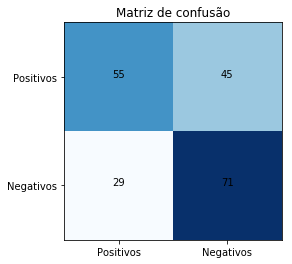

In [0]:
# Plotar matriz de confusão

rotulos_previstos = knn.predict(img_test_descritores)
matriz = confusion_matrix(rotulos_teste, rotulos_previstos)


plt.imshow(matriz,cmap=plt.cm.Blues,interpolation='nearest')
plt.title("Matriz de confusão")

labels = ['Positivos', 'Negativos']

marcador_escalas = range(len(labels))

plt.yticks(marcador_escalas,labels)
plt.xticks(marcador_escalas,labels)


for linha in range(matriz.shape[0]):
    for coluna in range(matriz.shape[1]):
        plt.text(coluna,linha,format(matriz[linha,coluna]),horizontalalignment='center',color='black')
plt.show();

## Plot Data Set

In [0]:
!pip install yellowbrick

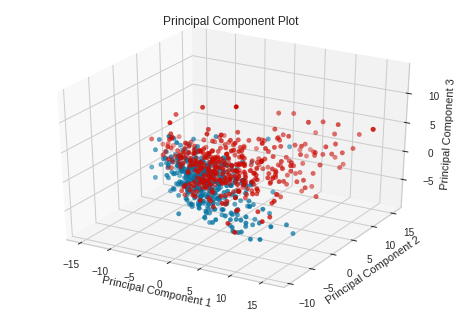

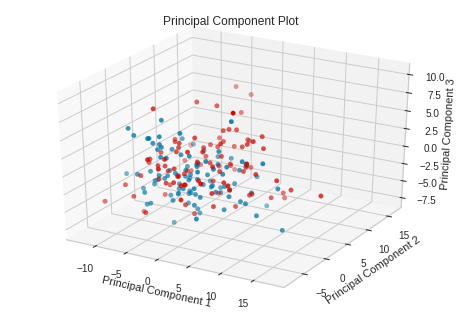

In [0]:
from yellowbrick.features.pca import PCADecomposition

cores_treinamento = np.array(['r' if label == 0 else 'b' for label in rotulos])

visualizar_dados_treinamento = PCADecomposition(scale=True, color=cores_treinamento, proj_dim=3)
visualizar_dados_treinamento.fit_transform(descritores, rotulos)
visualizar_dados_treinamento.poof()

cores_teste = np.array(['r' if label == 0 else 'b' for label in rotulos_teste])

visualizar_dados_teste = PCADecomposition(scale=True, color=cores_teste, proj_dim=3)
visualizar_dados_teste.fit_transform(img_test_descritores, rotulos_teste)
visualizar_dados_teste.poof()